# Imports and configs

In [23]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from random import gauss
from random import seed
from pandas import Series
from pandas.plotting import autocorrelation_plot
from matplotlib import pyplot
from plotly.subplots import make_subplots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox

In [2]:
pd.options.plotting.backend = "plotly"

In [3]:
data_path = "https://storage.googleapis.com/edulabs-public-datasets/callcenter.csv"

# Load the data

In [4]:
df = pd.read_csv(data_path, parse_dates=['QueueStartDate'], dayfirst=True)

In [30]:
df.head()

,QueueStartDate,QueueStartDateName,Interval,CallTypeName,CallsOffered,CallsAnswered,CallsAbonded,CallbackRequest,CallsTransfered,WaitDuration,...,CallDuration,MaxCallDuration,AvgCallDuration,P_CallsAnswered,P_CallsAbonded,P_CallsTransfered,P_CallbackRequest,TotalAgents,TotalSupervisors,TotalAgentsAndSupervisors
0,2024-01-01,Monday,08:00 - 08:30,HdKamuti,2,1,1,0,0,933,...,116,116,116,50.00,50.00,0.0,0.00,36.0,2.0,38.0
1,2024-01-01,Monday,08:00 - 08:30,ShlihimCB,7,6,1,0,0,414,...,1029,503,171,85.71,14.29,0.0,0.00,36.0,2.0,38.0
2,2024-01-01,Monday,08:30 - 09:00,HouseDelivery,6,5,0,1,0,83,...,596,283,99,100.00,0.00,0.0,16.67,42.0,2.0,44.0
3,2024-01-01,Monday,08:30 - 09:00,SuperVisor_L,6,5,1,0,0,149,...,1428,435,285,83.33,16.67,0.0,0.00,42.0,2.0,44.0
4,2024-01-01,Monday,09:00 - 09:30,Appointments,58,41,7,10,0,14956,...,3401,181,66,87.93,12.07,0.0,17.24,44.0,3.0,47.0


# Preprocess the data

- Create a pandas series with date index, series should contain one element (row) per total callsOffered per day
- We are going to analyze and later predict amount of calls per day


In [5]:
ts = df[['QueueStartDate', 'CallsOffered']].set_index('QueueStartDate').squeeze().groupby(pd.Grouper(freq='D')).sum()

In [14]:
#ts.reset_index()["QueueStartDate"].dt.isocalendar().week

# Data visualization

Display various plots and try to determine the following:
- Does data have structure or it looks like white noise / random walk
- Is there a trend in data?
- Is there seasonality?

Try the following plots:
- Lines
- Histograms
- Boxes
- Heat maps
- Other

In [6]:
ts.plot()

In [16]:
px.box(ts, color=ts.index.day_name())

In [17]:
px.box(ts, color=ts.index.month_name())

# Is data stationary?

**Determine whether your data is stationary, and if not - remove trends / seasonalities**

1. Run ADF test to find whther your data is stationary
2. If the data is not stationary - use differencing techniques to remove trend and seasonality
3. Run ADF test again after performing differencing to see whether data is stationary.
4. Run steps 2-3 again if needed

In [19]:
# Run ADF test
result = adfuller(ts)

# Display results
print("ADF Statistic:", result[0])
print("p-value:", result[1])
for key, value in result[4].items():
    print(f"Critical Value ({key}): {value}")

ADF Statistic: -3.193718023210919
p-value: 0.02035119645709602
Critical Value (1%): -3.44911857009962
Critical Value (5%): -2.8698097654570507
Critical Value (10%): -2.5711757061225153


In [20]:
# lets try and remove seasonality (weekly)
ts.diff(7).dropna().plot()

The data looks quite stationary with some anomalies
- the drops in calls might indicate holidays (we can axtually double-check it with hebrew calendar)
- the peaks need to be explained

In [33]:
# prompt: get israel public holidays in 2024

import holidays

il_holidays = holidays.Israel(years=2024)

for date, name in sorted(il_holidays.items()):
    print(date, name)


2024-04-23 Pesach
2024-04-29 Seventh day of Pesach
2024-05-14 Independence Day (observed)
2024-06-12 Shavuot
2024-10-03 Rosh Hashanah
2024-10-04 Rosh Hashanah
2024-10-12 Yom Kippur
2024-10-17 Sukkot
2024-10-24 Simchat Torah / Shemini Atzeret


In [21]:
# Run ADF test
result = adfuller(ts.diff(7).dropna())

# Display results
print("ADF Statistic:", result[0])
print("p-value:", result[1])
for key, value in result[4].items():
    print(f"Critical Value ({key}): {value}")

ADF Statistic: -6.465515040688818
p-value: 1.4085013334427812e-08
Critical Value (1%): -3.4495033946549123
Critical Value (5%): -2.8699787979596136
Critical Value (10%): -2.5712658305164955


In [22]:
detrended = ts.diff(7).dropna()

In [32]:
px.box(detrended, color=detrended.index.month_name())

# Now, after the data is stationary - check whether it's white noise (can it be forecasted at all?)

- Display ACF plot and check for auto-correlation
- Run Ljung-Box Test


Reminder:
**Autocorrelation Plot (ACF)**
- If no significant autocorrelation at any lag → likely white noise.
- If significant autocorrelation at lag 1 or others → likely AR process (i.e., a differenced random walk).

**Ljung-Box Test**
- A high p-value → series are like white noise
- A low p-value → autocorrelation exists - not a white noise


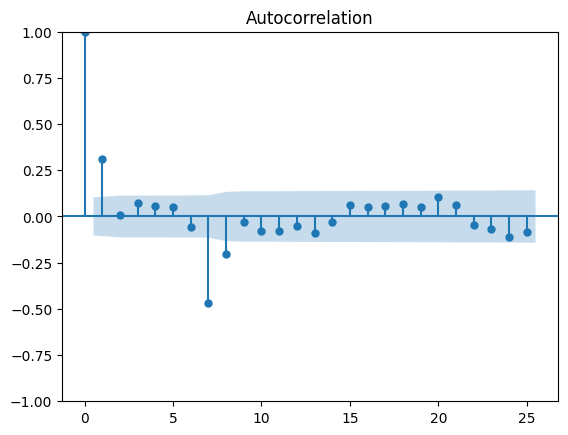

In [26]:
plot_acf(detrended, lags=25) # Adjust lags as needed
plt.show()

We can clearly see autogorrelation with 1 lag

In [28]:
lb_test = acorr_ljungbox(detrended, lags=10, return_df=True)
print(lb_test)

       lb_stat     lb_pvalue
1    34.904206  3.463318e-09
2    34.925773  2.605942e-08
3    36.953142  4.707625e-08
4    38.193832  1.021984e-07
5    39.255928  2.109156e-07
6    40.560929  3.533428e-07
7   120.361030  6.443320e-23
8   135.190265  2.370364e-25
9   135.581383  8.413827e-25
10  137.948613  1.108982e-24


The data is not a noise by all means and we should be able to forecast it